# Estimating Causal Effect of Graduate Education on Income with propensity score-based methods

In [49]:
import pickle

import dowhy
from dowhy import CausalModel

import pandas as pd
import numpy as np

## Load data

In [50]:
try:
    print(f"[INFO] Using pandas version: {pd.__version__}")
    with open("data/df_propensity_score.p", "rb") as f:
        df = pickle.load(f)
except:
    print("[INFO] Downgrading pandas to 1.5 to load the data...")
    !conda install -q -y pandas=1.5
    with open("data/df_propensity_score.p", "rb") as f:
        df = pickle.load(f)

df.head()

[INFO] Using pandas version: 1.5.3


,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


## Estimating causal effects with `dowhy`

In [51]:
model = CausalModel(
    data=df,
    treatment="hasGraduateDegree",
    outcome="greaterThan50k",
    common_causes="age"
)
model

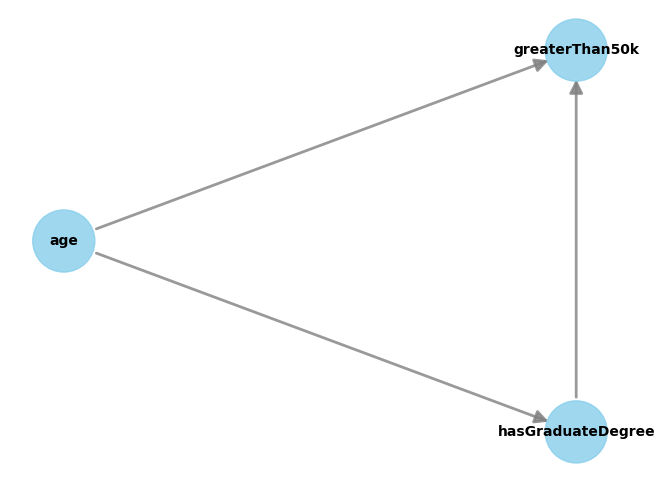

In [52]:
# View model
model.view_model()

### 2. Generate a statistical estimand

In [53]:
# Identify the statistical estimand from data
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## 3. Estimate causal effect (ATE) using 3 different propensity score-based appraoches
1. Matching
2. Stratification
3. IPTW (Inverse probability of treatment weighting)

In [ ]:
# Create a list of propensity score methods
ps_method_list = ["matching", "stratification", "weighting"]

# Create a dictionary to store the results
ps_estimate_dict = {}

# Estimate causal effect
for method in ps_method_list:
    ps_estimate = model.estimate_effect(identified_estimand,
                                        method_name=f"backdoor.propensity_score_{method}",
                                        confidence_intervals=False,
                                        method_params={})
    # Add estimates to the dictionary
    ps_estimate_dict[method] = ps_estimate.value

# Convert the dictionary into dataframe
ps_estimate_df = pd.DataFrame([ps_estimate_dict])
ps_estimate_df.head()

,matching,stratification,weighting
0,0.002811,0.294865,0.33124


In [48]:
# Compute mean effect across methods
ps_estimate_df.mean(axis=1)

0    0.209639
dtype: float64

It can be interpeted as: Having a graduate degree will increase the chance of getting more 50k income by 20%.

**Note:** Aggregating the causal effects across these 3 methods gives a very similar result (approx. 0.2) as the one we calculated in the causal inference notebook where we estimate ATE with a meta learner.